# <center> UC Weather Analysis
## <center> December 10, 2021
#### <center>Selam Berekat 
#### <center>Jinghong Chen 
#### <center>Ankita Giri
#### <center>Cecilia Nguyen
#### <center>Wyatt Workman


# 1. Introduction
In this project, we will investigate how climate change has impacted the UC system by selecting five UC campuses of interest. The selected five UCs are: UC Berkeley, UC Davis, UCLA, UC Santa Cruz and UC Santa Barbara. 

We will examine the historical climate data such as maximum temperature, minimum temperature and precipitation values for analyzing trends over the span of 20 years(2000-2020). The project uses NOAA Climatic Data Center (NCDC)'s Climate Data Online (CDO) API. The documentation for the data can be found [here](https://www.ncdc.noaa.gov/cdo-web/webservices/v2 "Documentation for CDO"). For using the API, an access token was required which was received by making a [request](https://www.ncdc.noaa.gov/cdo-web/token "API Access Token Request") via NOAA's website. We use five weather [stations](https://www.ncdc.noaa.gov/cdo-web/datatools/findstation) close to the selected UCs in the API calls. 

In this project, we aim to meet the following five criteria:
-  Project organization, writeup readability, and overall conclusions
- Code quality, readability, and efficiency
- Data munging
- Data visualization
- Data extraction

# 2. Scraping Data
We will begin by scraping data from weather stations found near each of the UC's we will focus on, using the NOAA API.

In [36]:
#import libraries
import requests
import json
import pandas as pd
import datetime
import itertools
from itertools import repeat
import matplotlib
import matplotlib.pyplot as pt
from matplotlib import dates as dt
from matplotlib import style
import numpy as np
style.use('seaborn-darkgrid')
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates
from matplotlib import gridspec
import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import data

In [2]:
#create list of years for querying API
dates = pd.date_range(start = "01-01-2000", end = "12-31-2020", freq = 'Y')#get years
dates = dates.strftime("%Y")#extract year 
dates = dates.to_list() #put dates into a python list

## 2.1. Data for UC Berkeley:

In [3]:
#Call API to gather data from 01-01-2000 to 12-31-2020
Token = 'sppyRslRxXMETktiexBiKTvMtnkNFfEX'#API token
station_id = "GHCND:USC00040693"#station data used for UC Berkeley
#setup lists to store data
date_rain = []
date_tmax = []
date_tmin = []
rain_lst = []
tmin_lst = []
tmax_lst = []
#query API for data of interest:
for i in dates: #loop through list of years and append them to API call where appropriate
    temp_max = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
    rain = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=PRCP&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})
    temp_min = requests.get("https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMIN&limit=1000&stationid=GHCND:USC00040693&units=standard&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31", headers={'token':Token})

    #convert to JSON:
    rain = rain.json()
    tmin = temp_min.json()
    tmax = temp_max.json()

    #create dataframe for each API call:
    rain_table = pd.json_normalize(rain["results"])
    tmin_table = pd.json_normalize(tmin["results"])
    tmax_table = pd.json_normalize(tmax["results"])

    #append data to appropriate list in order to construct overall dataset for UC Berkeley:
    date_rain.append(rain_table["date"].tolist())
    rain_lst.append(rain_table["value"].tolist())
    date_tmin.append(tmin_table['date'].tolist())
    tmin_lst.append(tmin_table['value'].tolist())
    date_tmax.append(tmax_table['date'].tolist())
    tmax_lst.append(tmax_table['value'].tolist())

#create dataset with date and value for each paramter of interest:
rain_data = pd.DataFrame({
    "Date":list(itertools.chain.from_iterable(date_rain)),
    "Precip":list(itertools.chain.from_iterable(rain_lst))
})

tmax_data = pd.DataFrame({
    "Date":list(itertools.chain.from_iterable(date_tmax)),
    "tmax":list(itertools.chain.from_iterable(tmax_lst))
})

tmin_data = pd.DataFrame({
    "Date": list(itertools.chain.from_iterable(date_tmin)),
    "tmin":list(itertools.chain.from_iterable(tmin_lst))
})



In [192]:
#clean dates and set indices for merge:

#clean date variable:
rain_data.index = pd.to_datetime(rain_data.index)
tmax_data.index = pd.to_datetime(tmax_data.index)
tmin_data.index = pd.to_datetime(tmin_data.index)

#set date as index for each dataframe:
#rain_data = rain_data.set_index("Date")
#tmax_data = tmax_data.set_index("Date")
#tmin_data = tmin_data.set_index("Date")

#merge datasets into 1 dataset:
berk_dat = tmax_data.merge(tmin_data, how="left",left_index=True, right_index=True)
berk_dat = berk_dat.merge(rain_data, how = "inner", left_index = True, right_index=True)
berk_dat["average"] = berk_dat["tmin"] + ((berk_dat["tmax"]-berk_dat["tmin"])/2) #compute average temperature
#compute difference between max and min temperature:
berk_dat["difference"] = berk_dat.eval("tmax - tmin")
berk_dat = berk_dat.dropna()

In [195]:
#show dataset:
berk_dat.head()

,tmax,tmin,Precip,average,difference
Date,,,,,
2000-01-01,50.0,45.0,0.00,47.5,5.0
2000-01-02,53.0,40.0,0.00,46.5,13.0
2000-01-03,55.0,42.0,0.00,48.5,13.0
2000-01-04,55.0,42.0,0.05,48.5,13.0
2000-01-05,56.0,40.0,0.00,48.0,16.0


## 2.2. Data for UC Davis:

In [72]:
token = {'token':'dQaZxQlLzXdcKcbMHXEUYLpZztpnXSmW'} #API call token

list_result = [] #initializing an array

for i in range(2000,2021):
    response = requests.get(url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:USC00042294&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31&units=standard" , headers = token)
    jobj = response.json()
    df= pd.DataFrame(jobj['results'])
    list_result.append(df[['date', 'datatype', 'value']]) #list of the result dataframe while only keeping relevant variables 

df_davis = pd.concat(list_result)#change the above list of dataframes to one single dataframe
df_davis['date'] = pd.to_datetime(df_davis['date']) #change the date to the pandas date_time format
df_davis = df_davis.pivot_table(values = 'value', index = 'date',columns = 'datatype')  #change the factors in the `datatype` into columns
df_davis = df_davis.reset_index() #reset the index to keep the dates as a column
df_davis['year'] = df_davis['date'].dt.year #column for keeping only the year from the date 
#df_davis.isna().sum()
df_davis.dropna()

#Take average of all values according to the year
year_df_mean_davis = df_davis.groupby('year').mean().reset_index()
year_df_mean_davis['diff'] = year_df_mean_davis['TMAX'] - year_df_mean_davis['TMIN'] #create a new column of the avg max and min temperature 
year_df_mean_davis.head()

datatype,year,PRCP,TMAX,TMIN,diff
0,2000,0.056578,75.845455,49.598187,26.247267
1,2001,0.044760,78.390390,49.828829,28.561562
2,2002,0.024239,77.302395,48.341390,28.961005
3,2003,0.036946,77.288288,49.627628,27.660661
4,2004,0.046254,74.667702,48.541796,26.125906


## 2.3: Data for UCLA:

In [18]:
#get sample URL and setup endpoints
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
Token = "pVNnatMYsXAaijcyPESlaNXivnMrJtFk"
params = {'datasetid': 'GHCND', 'datatypeid': 'TMAX','limit': '1000', 'stationid': 'GHCND:USW00023174', \
          'units': 'standard', 'startdate': '2000-01-01','enddate': '2000-12-31'} #dictionary of endpoints
req = requests.get(url,params=params,headers={'token':Token})
js = req.json()
req.url

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&stationid=GHCND%3AUSW00023174&units=standard&startdate=2000-01-01&enddate=2000-12-31'

In [22]:
df = pd.DataFrame()
df_lst = [] #list of dataframes for each year
year =  list(range(2000,2021))
for i in dates:
    #daily high temperature dataframe
    params['startdate'] = str(i)+'-01-01'
    params['enddate'] = str(i)+'-12-31'
    params['datatypeid'] = 'TMAX'
    tmax = requests.get(url,params=params,headers={'token':Token}) #query API
    tmax_temp = pd.DataFrame(tmax.json()['results'])
    tmax_temp['date'] = pd.to_datetime(tmax_temp['date']) #convert date to datetime object
    tmax_temp = tmax_temp.rename(columns={"value": "max_temperature"})
    tmax_temp = tmax_temp.set_index('date').drop(['datatype'], axis=1)
    
    #daily low temp dataframe
    params['datatypeid'] = 'TMIN'
    tmin = requests.get(url,params=params,headers={'token':Token}) #convert date to datetime object
    tmin_temp = pd.DataFrame(tmin.json()['results'])
    tmin_temp['date'] = pd.to_datetime(tmin_temp['date'])
    tmin_temp = tmin_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    tmin_temp = tmin_temp.rename(columns={"value": "min_temperature"})
    df_temp = tmax_temp.join(tmin_temp)
    
    #daily precipitation totals dataframe
    params['datatypeid'] = 'PRCP'
    prcp = requests.get(url,params=params,headers={'token':Token}) #convert date to datetime object
    prcp_temp = pd.DataFrame(prcp.json()['results'])
    prcp_temp['date'] = pd.to_datetime(prcp_temp['date'])
    prcp_temp = prcp_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1)
    prcp_temp = prcp_temp.rename(columns={"value": "rain"})
    df_temp = df_temp.join(prcp_temp)
    
    df_lst.append(df_temp) #add each dataframe to list
ucla_dat = pd.concat(df_lst) #merge all dataframes into 1

In [23]:
ucla_dat['diff'] = ucla_dat.eval('max_temperature - min_temperature') #create difference column.

In [30]:
ucla_dat.head()

,station,attributes,max_temperature,min_temperature,rain,diff
date,,,,,,
2000-01-01,GHCND:USW00023174,",,0,2400",58.0,46.0,0.0,12.0
2000-01-02,GHCND:USW00023174,",,0,2400",60.0,48.0,0.0,12.0
2000-01-03,GHCND:USW00023174,",,0,2400",66.0,44.0,0.0,22.0
2000-01-04,GHCND:USW00023174,",,0,2400",69.0,47.0,0.0,22.0
2000-01-05,GHCND:USW00023174,",,0,2400",70.0,43.0,0.0,27.0


## 2.4. Data for UC Santa Barbara:

In [26]:
#setup API endpoints
url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
Token = "eLCmbnPGUBzvYdVYFMZYpulbSoXjYkfX"
params = {'datasetid': 'GHCND', 'datatypeid': 'TMAX','limit': '1000', 'stationid': 'GHCND:USW00023190', \
          'units': 'standard', 'startdate': '2000-01-01','enddate': '2000-12-31'} #dictionary of endpoints
req = requests.get(url,params=params,headers={'token':Token})
js = req.json()
req.url

'https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&datatypeid=TMAX&limit=1000&stationid=GHCND%3AUSW00023190&units=standard&startdate=2000-01-01&enddate=2000-12-31'

In [27]:
df_lst = [] #list of dataframes for each year
year =  list(range(2000,2021))
df = pd.DataFrame()
for i in year:
    #max temperature dataframe
    params['startdate'] = str(i)+'-01-01'
    params['enddate'] = str(i)+'-12-31'
    params['datatypeid'] = 'TMAX'
    tmax = requests.get(url,params=params,headers={'token':Token}) #query API
    tmax_temp = pd.DataFrame(tmax.json()['results'])
    tmax_temp['date'] = pd.to_datetime(tmax_temp['date'])
    tmax_temp = tmax_temp.rename(columns={"value": "max_temperature"})
    tmax_temp = tmax_temp.set_index('date').drop(['datatype'], axis=1)
    
    #min temp dataframe
    params['datatypeid'] = 'TMIN'
    tmin = requests.get(url,params=params,headers={'token':Token})
    tmin_temp = pd.DataFrame(tmin.json()['results'])
    tmin_temp['date'] = pd.to_datetime(tmin_temp['date'])
    tmin_temp = tmin_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1) #query api
    tmin_temp = tmin_temp.rename(columns={"value": "min_temperature"})
    df_temp = tmax_temp.join(tmin_temp)
    
    #daily precipitation totals dataframe
    params['datatypeid'] = 'PRCP'
    prcp = requests.get(url,params=params,headers={'token':Token})
    prcp_temp = pd.DataFrame(prcp.json()['results'])
    prcp_temp['date'] = pd.to_datetime(prcp_temp['date'])
    prcp_temp = prcp_temp.set_index('date').drop(['station', 'attributes','datatype'], axis=1) #queri API
    prcp_temp = prcp_temp.rename(columns={"value": "rain"})
    df_temp = df_temp.join(prcp_temp)
    
    df_lst.append(df_temp)

ucsb_dat = pd.concat(df_lst)

In [28]:
ucsb_dat['diff'] = ucsb_dat.eval('max_temperature - min_temperature')

In [29]:
ucsb_dat.head()

,station,attributes,max_temperature,min_temperature,rain,diff
date,,,,,,
2000-01-01,GHCND:USW00023190,",,W,2400",65.0,41.0,0.0,24.0
2000-01-02,GHCND:USW00023190,",,W,2400",69.0,44.0,0.0,25.0
2000-01-03,GHCND:USW00023190,",,W,2400",66.0,38.0,0.0,28.0
2000-01-04,GHCND:USW00023190,",,W,2400",67.0,36.0,0.0,31.0
2000-01-05,GHCND:USW00023190,",,W,2400",71.0,42.0,0.0,29.0


## 2.5: Data for UC Santa Cruz:

In [78]:
token = 'tqQNQJTPRxOCdAucFBalBaEXMRnkZjvo' #web services token request to get access API
df = []
for i in range(2000,2021): #start and end parameters can only do one year so this is how you'll get all the years
    response = requests.get(url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid=GHCND&stationid=GHCND:USC00047916&datatypeid=TMAX&datatypeid=TMIN&datatypeid=PRCP&limit=1000&startdate="+str(i)+"-01-01&enddate="+str(i)+"-12-31&units=standard" , headers = {'token': token})
    response_js = response.json()
    #print(response_js)
    df_temp = pd.DataFrame(response_js["results"]) #want results part
    #print(df)  #df has to be in loop to get all the years  
    df.append(df_temp[['date', 'datatype', 'value']]) #get columns you want
#print(df) #appended entire dataframe to list to keep all the years, so won't have to work under for loop
station_df = pd.concat(df) #make list of iterated dataframes to one dataframe
station_df['date'] = pd.to_datetime(station_df['date'])
#print(station_df)
ucsc_dat = station_df.pivot_table('value', ['date'], 'datatype').reset_index()#leave date, make datatypes the columns and value as the column values corresponding to it, reset index to get own column for date
#print(station_df)
ucsc_dat['year'] = ucsc_dat['date'].dt.year #make year column getting year from datetime
ucsc_dat.head()
#station_df.year.dtype

datatype,date,PRCP,TMAX,TMIN,year
0,2000-01-01,0.00,54.0,47.0,2000
1,2000-01-02,0.02,59.0,35.0,2000
2,2000-01-03,0.00,60.0,36.0,2000
3,2000-01-04,0.00,58.0,36.0,2000
4,2000-01-05,0.00,62.0,39.0,2000


# 3. Visualizations
Using the data for each UC campus, we will now visualize how average high and low temperatures have changed over time. Wel will also examine rainfall totals in this 20 year time period, and determine which campus has received the most rainfall, as well as which season tends to receive the most rainfall.

## 3.1: Average High Temperature Per Year
High temperatures tend to occur in the middle of the day. Visualizing how this has changed over time will allow us to determine if temperatures are becoming warmer on average.

In [124]:
#Plot data for UCBerkeley:
mon_df_berk = berk_dat.copy()
mon_df_berk = mon_df_berk.reset_index()
mon_df_berk["Date"] = pd.to_datetime(mon_df_berk["Date"]).dt.strftime("%Y-%m") #strip datetime to month and year
year_df_berk = mon_df_berk.copy()
year_df_berk["Date"] = pd.to_datetime(year_df_berk["Date"]).dt.strftime("%Y") #strip datetime to year

In [125]:
#Plot data for UCLA:
mon_df_ucla = ucla_dat.copy()
mon_df_ucla = mon_df_ucla.reset_index()
mon_df_ucla["date"] = pd.to_datetime(mon_df_ucla["date"]).dt.strftime("%Y-%m") #strip datetime to month and year
year_df_ucla = mon_df_ucla.copy()
year_df_ucla["date"] = pd.to_datetime(year_df_ucla["date"]).dt.strftime("%Y") #strip datetime to year

In [126]:
#plot data for UC Santa Barbara:
mon_df_ucsb = ucsb_dat.copy()
mon_df_ucsb = mon_df_ucsb.reset_index()
mon_df_ucsb["date"] = pd.to_datetime(mon_df_ucsb["date"]).dt.strftime("%Y-%m") #strip datetime to month and year
year_df_ucsb = mon_df_ucsb.copy()
year_df_ucsb["date"] = pd.to_datetime(year_df_ucsb["date"]).dt.strftime("%Y") #strip datetime to year

In [127]:
#plot data for UCSC:
year_df_mean_ucsc = ucsc_dat.groupby('year').mean().reset_index() #mean of all columns 
year_df_mean_ucsc['diff'] = year_df_mean_ucsc['TMAX'] - year_df_mean_ucsc['TMIN'] #calculate difference between max and min temperature.

In [128]:
#create plots:
#ucberkeley
year_df_berk_mean = year_df_berk.groupby(['Date']).mean().reset_index()#average high temp for each year in dataset
p1 = p9.ggplot(year_df_berk_mean) + p9.aes(x='Date',y='tmax',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(65,82) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UC Berkeley)")

#ucla:
year_df_ucla_mean = year_df_ucla.groupby(['date']).mean().reset_index() #average high temp for each year in dataset
p2 = p9.ggplot(year_df_ucla_mean) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(65,82) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UCLA)")

#UCSB:
year_df_ucsb_mean = year_df_ucsb.groupby(['date']).mean().reset_index() #average high temp for each year in dataset
p3 = p9.ggplot(year_df_ucsb_mean) + p9.aes(x='date',y='max_temperature',group = 1) + \
p9.ylim(65,82) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UCSB)")

#UC Davis:
p4 = p9.ggplot(year_df_mean_davis) + p9.aes(x='year',y='TMAX',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(65,82) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UC Davis)") 

#UCSC:
p5 = p9.ggplot(year_df_mean_ucsc) + p9.aes(x='year',y='TMAX',group = 1) + \
p9.ylim(65,82) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average max temperature per year from 2000 to 2020 (UC Santa Cruz)")

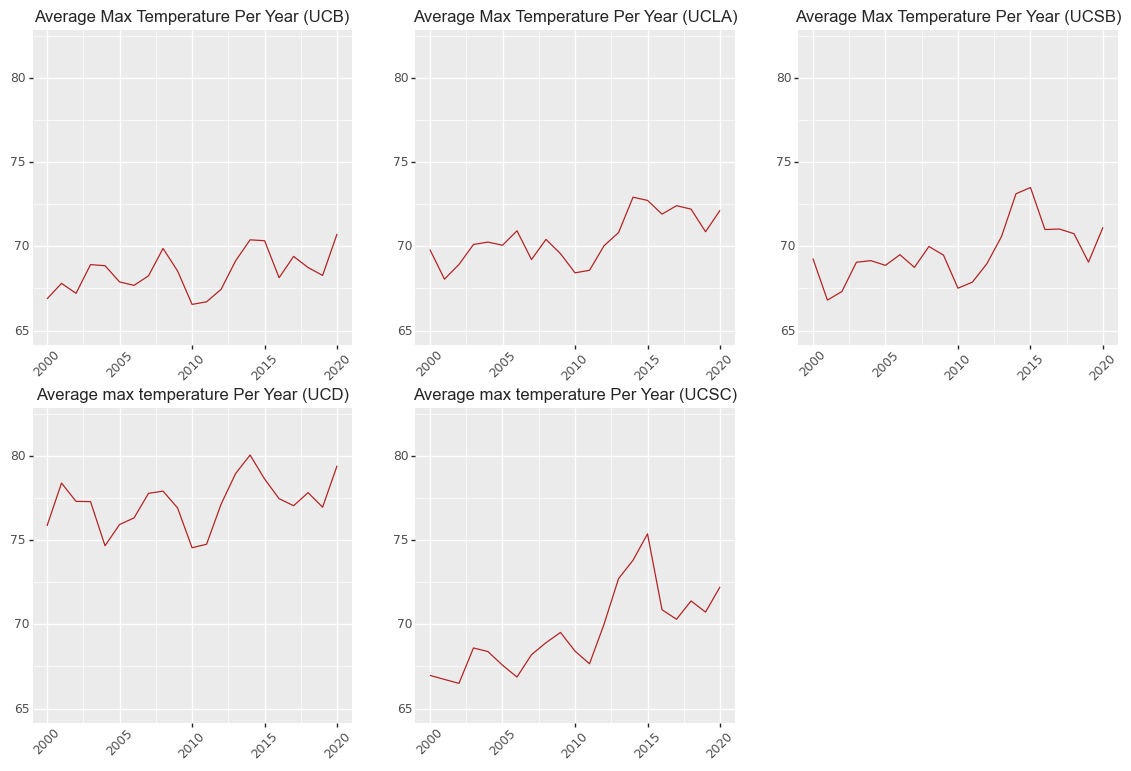

In [129]:
#combine all plots:
fig = (p9.ggplot()+p9.geom_blank(data=data.diamonds)+p9.theme_void()).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(2,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])

#Add subplot titles:
ax1.set_title("Average Max Temperature Per Year (UCB)")
ax2.set_title("Average Max Temperature Per Year (UCLA)")
ax3.set_title("Average Max Temperature Per Year (UCSB)")
ax4.set_title("Average max temperature Per Year (UCD)")
ax5.set_title("Average max temperature Per Year (UCSC)")

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])
_ = p4._draw_using_figure(fig, [ax4])
_ = p5._draw_using_figure(fig, [ax5])

#set figure size.
fig.set_size_inches(14,9)



### Findings:
These plots demonstrate the average maximum temperature throughout the twenty years in the selected UC's. We observe a trend happening in 2014 for most of them. Due to abnormally hot weather in California, 2014 was considered the hottest year in California history. We also notice the line increasing dramatically for all and then dropping down slowly in the following years. While it gradually climbs to getting warmer in 2017 onwards. 

We observe that UC Davis is the warmest place to live because their maximum temperature lies between 75 to 80 degrees(F). UC Berkeley has a moderate maximum temperature that lies between 65 to 70 degrees(F).

Finally, from these visualizations we learn that due to climate change the overall trend of weather on the selected UC's show an increase on maximum temperature these past 10 years, from 2010-2020. This shows us that in the last 10 years, high temperatures are increasing in magnitude, showing that the weather is becoming warmer at all of the UC campuses. 

## 3.2. Average Temperature Difference per Year from 2000 to 2020:
These plots will demonstrate the average differene between high and low temperatures each year. This is important because large differences between high and low temperature are a way to visualize how extreme temperature fluctuations are for a given time period. Due to climate change, we expect that over time, these differences will become more extreme. Knowledge of these extrema will allow the UC system to prepare for more extreme temperatures and weather events.

In [146]:
#create plots:
#ucberkeley
year_df_berk_mean = year_df_berk.groupby(['Date']).mean().reset_index()#average high temp for each year in dataset
p1 = p9.ggplot(year_df_berk_mean) + p9.aes(x='Date',y='difference',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(10,35) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UC Berkeley)")

#ucla:
year_df_ucla_mean = year_df_ucla.groupby(['date']).mean().reset_index()
p2 = p9.ggplot(year_df_ucla_mean) + p9.aes(x='date',y='diff',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(10,35) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UCLA)")

#UCSB:
year_df_ucsb_mean = year_df_ucsb.groupby(['date']).mean().reset_index()
p3 = p9.ggplot(year_df_ucsb_mean) + p9.aes(x='date',y='diff',group = 1) + \
p9.ylim(10,35) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UCSB)")

#UC Davis:
p4 = p9.ggplot(year_df_mean_davis) + p9.aes(x='year',y='diff',group = 1) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.ylim(10,35) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UC Davis)") 

#UCSC:
p5 = p9.ggplot(year_df_mean_ucsc) + p9.aes(x='year',y='diff',group = 1) + \
p9.ylim(10,35) + \
p9.geom_line(color='firebrick') + p9.themes.theme(axis_text_x=p9.element_text(angle=45)) + \
p9.labs(x = "Year", y = "Average max temperature (°F)", \
     title = "Average temperature difference per year from 2000 to 2020 (UC Santa Cruz)")

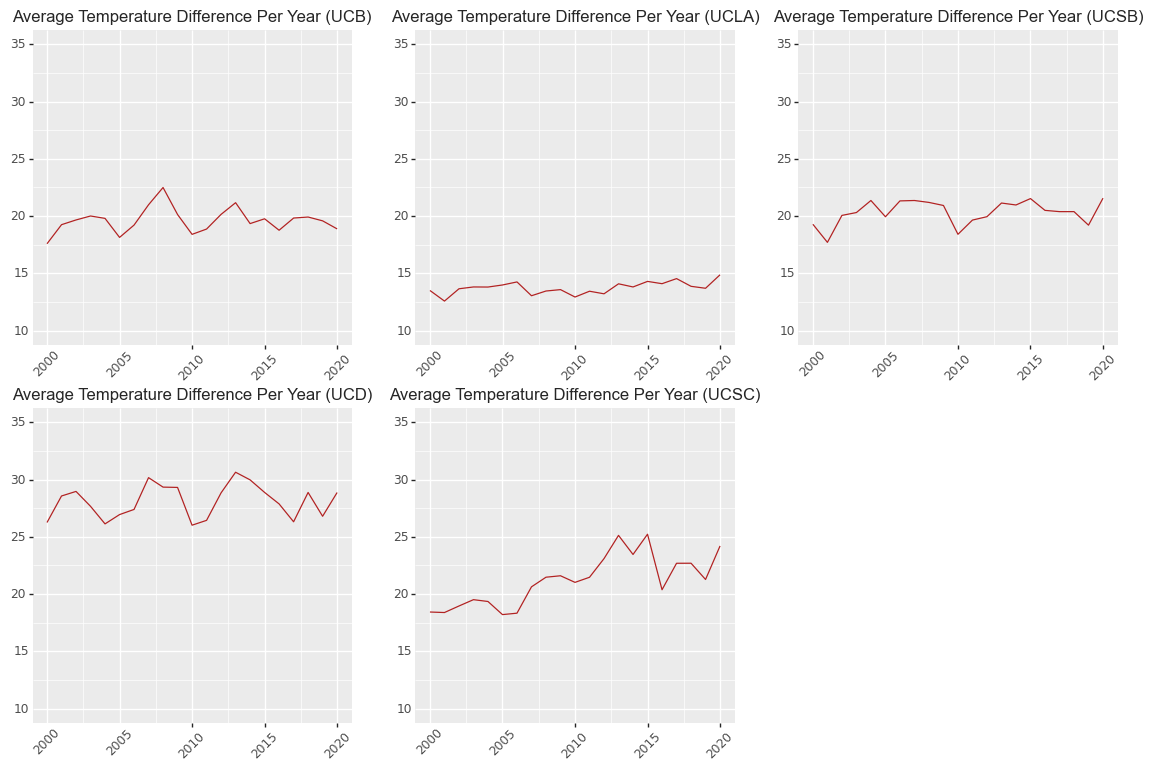

In [147]:
#combine all plots:
fig = (p9.ggplot()+p9.geom_blank(data=data.diamonds)+p9.theme_void()).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(2,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])

#Add subplot titles:
ax1.set_title("Average Temperature Difference Per Year (UCB)")
ax2.set_title("Average Temperature Difference Per Year (UCLA)")
ax3.set_title("Average Temperature Difference Per Year (UCSB)")
ax4.set_title("Average Temperature Difference Per Year (UCD)")
ax5.set_title("Average Temperature Difference Per Year (UCSC)")

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])
_ = p4._draw_using_figure(fig, [ax4])
_ = p5._draw_using_figure(fig, [ax5])

fig.set_size_inches(14,9)



### Findings:
Here, the plots illustrate the average temperature difference per the selected UC's throughout the twenty years time period. We observe that UCLA has no big difference between maximum and minimum temperature, whereas the other UC's have slight differences and this can indicate that for some of the years, during the day the weather might be very warm and during the night the weather can get quite cold. 

For example, if we observe UCB in between 2005 and 2010 they had a large peak showing that there was a great amount of difference. This can indicate when the climate change intensifies, events of dangerous weather can become more frequent and severe. We can reach similar conclusions for UCSC, where they have multiple fluctuation of temperature difference throughout 10 years (from 2005 upto 2015). On the other hand, UCSB plot shows multiple negative peak which can indicate a negative temperature difference.

By examining the peaks on each graph, we can see that all the UC's except for UCLA experience more drastic differences in temperature. Of these, UC Davis experiences the most drastic temperature differences. Another interesting trend to note is UCSC: here we can also observe that there is a linearly increasing trend, further showing that it is experiencing a warming climate. Since UCSC is the only plot that shows this trend, we can conclude that, thus far, UCSC has experienced more climate change-related warming than the other UC campuses.

## 3.3. Average High and Low Temperature Per Year from 2000 to 2020:
This plot will allow us to visualize average high and low temperatures by year for each UC campus, and is another way to determine how climate change is impacting the UC system.

In [164]:
#create plots:
#ucberkeley
year_df_berk_mean = year_df_berk.groupby(['Date']).mean().reset_index()#average high temp for each year in dataset
p1 = p9.ggplot(year_df_berk_mean, p9.aes(x='Date',y='tmin',group = 1)) + \
p9.geom_line(p9.aes(y='tmin', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='tmax', color='"firebrick"')) +\
p9.ylim(35,85) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020 (UC Berkeley)")

#ucla:
year_df_ucla_mean = year_df_ucla.groupby(['date']).mean().reset_index()
p2 = p9.ggplot(year_df_ucla_mean, p9.aes(x='date',y='min_temperature',group = 1)) + \
p9.geom_line(p9.aes(y='min_temperature', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='max_temperature', color='"firebrick"')) +\
p9.ylim(35,85) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020")

#UCSB:
year_df_ucsb_mean = year_df_ucsb.groupby(['date']).mean().reset_index()
p3 = p9.ggplot(year_df_ucsb_mean, p9.aes(x='date',y='min_temperature',group = 1)) + \
p9.geom_line(p9.aes(y='min_temperature', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='max_temperature', color='"firebrick"')) +\
p9.ylim(35,85) + \
p9.scale_x_datetime(date_breaks = "5 years", labels=date_format('%Y')) +\
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020")

#UC Davis:
p4 = p9.ggplot(year_df_mean_davis, p9.aes(x='year',y='TMIN',group = 1)) + \
p9.geom_line(p9.aes(y='TMIN', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='TMAX', color='"firebrick"')) +\
p9.ylim(35,85) + \
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020 (UC Davis)")

#UCSC:
p5 = p9.ggplot(year_df_mean_ucsc, p9.aes(x='year',y='TMIN',group = 1)) + \
p9.geom_line(p9.aes(y='TMIN', color='"darkblue"')) +\
p9.geom_line(p9.aes(y='TMAX', color='"firebrick"')) +\
p9.ylim(35,85) + \
p9.scale_color_identity(guide='legend', name = "Variable", breaks=['darkblue', 'firebrick'], 
                        labels=['Average minimum temperature', 'Average maximum temperature']) +\
p9.themes.theme(axis_text_x=p9.element_text(angle=45)) +\
p9.labs(x = "Year", y = "Temperature (°F)", \
     title = "Average max and min temperature per year from 2000 to 2020 (UC Santa Cruz)")

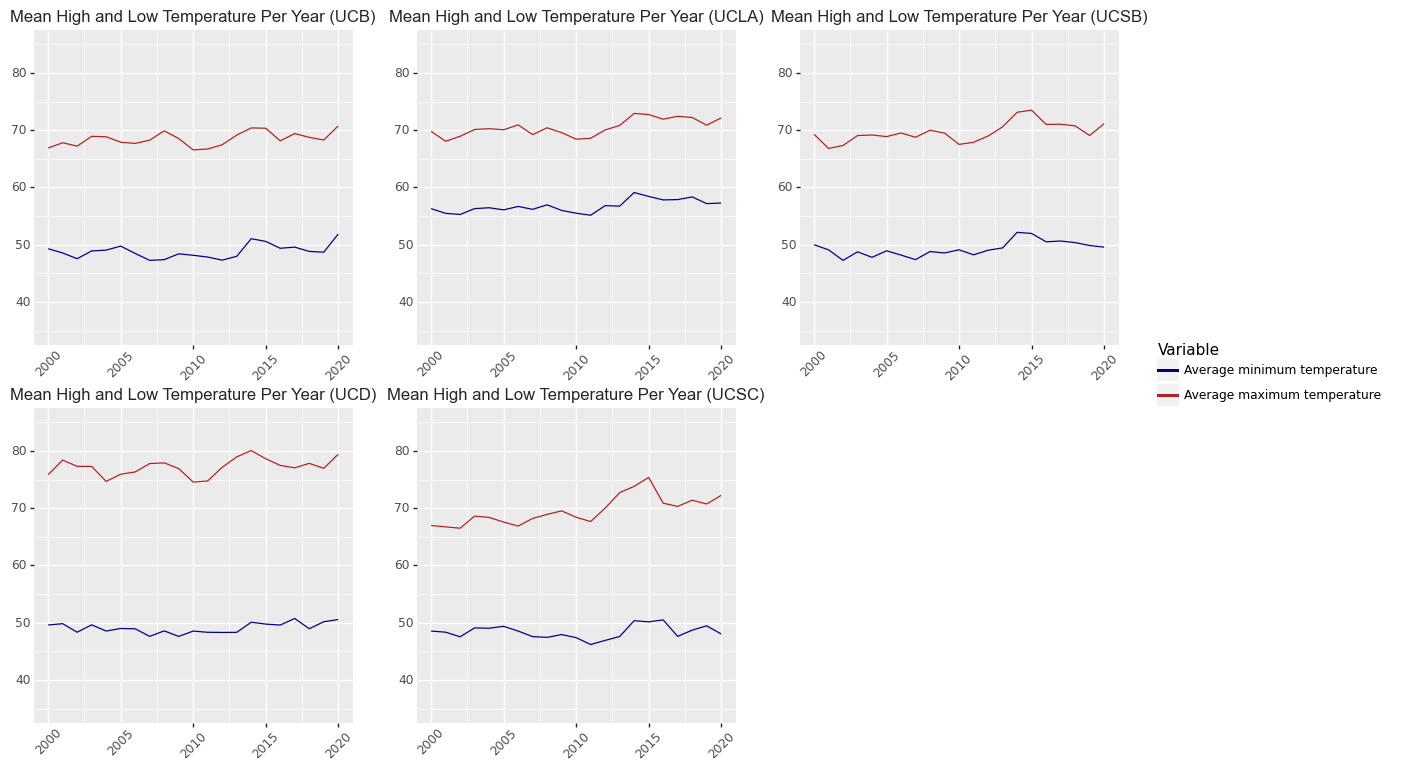

In [165]:
#combine all plots:
fig = (p9.ggplot()+p9.geom_blank(data=data.diamonds)+p9.theme_void()).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(2,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])

#Add subplot titles:
ax1.set_title("Mean High and Low Temperature Per Year (UCB)")
ax2.set_title("Mean High and Low Temperature Per Year (UCLA)")
ax3.set_title("Mean High and Low Temperature Per Year (UCSB)")
ax4.set_title("Mean High and Low Temperature Per Year (UCD)")
ax5.set_title("Mean High and Low Temperature Per Year (UCSC)")

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])
_ = p4._draw_using_figure(fig, [ax4])
_ = p5._draw_using_figure(fig, [ax5])

fig.set_size_inches(14,9)


### Interpretation:
This plots show the combination of both mean for the maximum and the minimum temperature for each selected UC. As we compare them and also observe from the previous plot, there seems that all of the selected UC's have experienced higher mean of high temperatures with slight increase on the mean of low temperatures over the time period.

Once again, we can see that UCSC shows the strongest increasing linear trend, especially with respect to average high temperature. Also, we can see that for all of the UC campuses, 2015-2020 have been warmer than average, as for both the high and low temperature, we note that the temperature averages are higher than the previous 15 years (2000-2015).

## 3.4. Total Rainfall By Season for each UC:
In this section, we visualize rainfall totals by season from 2000 to 2020. This will allow us to show which season tends to be the "rainiest" at each campus. We will also be able to obtain an idea of which campus has received the most rainfall, and therefore, which campus tends to be the wettest. Prospective applicants to the UC system may be interested in these plots, as they may influence applicants' choice on which campus to apply to, based on how they feel about wet weather.

In [173]:
#convert index to datetime format
berk_dat.index = pd.to_datetime(berk_dat.index)

In [200]:
#dataset for UC Berkeley:
season_df_ucb = berk_dat.copy()
season_df_ucb['year'] = season_df_ucb.index.year
season_df_ucb['month']= season_df_ucb.index.month
season_df_ucb = season_df_ucb.reset_index()
season_df_ucb['month'] = season_df_ucb['month'].astype(int)
season_df_ucb['season'] = season_df_ucb['month']%12 // 3 + 1
season_df_ucb.head()

,Date,tmax,tmin,Precip,average,difference,year,month,season
0,2000-01-01,50.0,45.0,0.00,47.5,5.0,2000,1,1
1,2000-01-02,53.0,40.0,0.00,46.5,13.0,2000,1,1
2,2000-01-03,55.0,42.0,0.00,48.5,13.0,2000,1,1
3,2000-01-04,55.0,42.0,0.05,48.5,13.0,2000,1,1
4,2000-01-05,56.0,40.0,0.00,48.0,16.0,2000,1,1


In [166]:
#dataset for UCLA:
season_df_ucla = ucla_dat.copy()
season_df_ucla['year'] = season_df_ucla.index.year
season_df_ucla['month']= season_df_ucla.index.month
season_df_ucla = season_df_ucla.reset_index()
season_df_ucla['month'] = season_df_ucla['month'].astype(int)
season_df_ucla['season'] = season_df_ucla['month']%12 // 3 + 1
season_df_ucla.head()

,date,station,attributes,max_temperature,min_temperature,rain,diff,year,month,season
0,2000-01-01,GHCND:USW00023174,",,0,2400",58.0,46.0,0.0,12.0,2000,1,1
1,2000-01-02,GHCND:USW00023174,",,0,2400",60.0,48.0,0.0,12.0,2000,1,1
2,2000-01-03,GHCND:USW00023174,",,0,2400",66.0,44.0,0.0,22.0,2000,1,1
3,2000-01-04,GHCND:USW00023174,",,0,2400",69.0,47.0,0.0,22.0,2000,1,1
4,2000-01-05,GHCND:USW00023174,",,0,2400",70.0,43.0,0.0,27.0,2000,1,1


In [175]:
#dataset for UCSB:
season_df_ucsb = ucsb_dat.copy()
season_df_ucsb['year'] = season_df_ucsb.index.year
season_df_ucsb['month']= season_df_ucsb.index.month
season_df_ucsb = season_df_ucsb.reset_index()
season_df_ucsb['month'] = season_df_ucsb['month'].astype(int)
season_df_ucsb['season'] = season_df_ucsb['month']%12 // 3 + 1
season_df_ucsb.head()

,date,station,attributes,max_temperature,min_temperature,rain,diff,year,month,season
0,2000-01-01,GHCND:USW00023190,",,W,2400",65.0,41.0,0.0,24.0,2000,1,1
1,2000-01-02,GHCND:USW00023190,",,W,2400",69.0,44.0,0.0,25.0,2000,1,1
2,2000-01-03,GHCND:USW00023190,",,W,2400",66.0,38.0,0.0,28.0,2000,1,1
3,2000-01-04,GHCND:USW00023190,",,W,2400",67.0,36.0,0.0,31.0,2000,1,1
4,2000-01-05,GHCND:USW00023190,",,W,2400",71.0,42.0,0.0,29.0,2000,1,1


In [178]:
#set index for ucd dataset:
df_davis = df_davis.set_index("date")

<bound method NDFrame.head of datatype    PRCP  TMAX  TMIN  year
date                              
2000-01-01  0.00  59.0  31.0  2000
2000-01-02  0.00  55.0  28.0  2000
2000-01-03  0.00  59.0  33.0  2000
2000-01-04  0.00  59.0  34.0  2000
2000-01-05  0.06  58.0  39.0  2000
...          ...   ...   ...   ...
2020-11-30  0.00  66.0  32.0  2020
2020-12-01  0.00  67.0  36.0  2020
2020-12-02  0.00  67.0  34.0  2020
2020-12-03  0.00  67.0  36.0  2020
2020-12-04  0.00   NaN   NaN  2020

[7060 rows x 4 columns]>

In [179]:
#dataset for UC Davis:
season_df_ucd = df_davis.copy()
season_df_ucd['year'] = season_df_ucd.index.year
season_df_ucd['month']= season_df_ucd.index.month
season_df_ucd = season_df_ucd.reset_index()
season_df_ucd['month'] = season_df_ucd['month'].astype(int)
season_df_ucd['season'] = season_df_ucd['month']%12 // 3 + 1
season_df_ucd.head()

datatype,date,PRCP,TMAX,TMIN,year,month,season
0,2000-01-01,0.00,59.0,31.0,2000,1,1
1,2000-01-02,0.00,55.0,28.0,2000,1,1
2,2000-01-03,0.00,59.0,33.0,2000,1,1
3,2000-01-04,0.00,59.0,34.0,2000,1,1
4,2000-01-05,0.06,58.0,39.0,2000,1,1


In [182]:
ucsc_dat = ucsc_dat.set_index("date")

In [183]:
#dataset for ucsc:
season_df_ucsc = ucsc_dat.copy()
season_df_ucsc['year'] = season_df_ucsc.index.year
season_df_ucsc['month']= season_df_ucsc.index.month
season_df_ucsc = season_df_ucsc.reset_index()
season_df_ucsc['month'] = season_df_ucsc['month'].astype(int)
season_df_ucsc['season'] = season_df_ucsc['month']%12 // 3 + 1
season_df_ucsc.head()

datatype,date,PRCP,TMAX,TMIN,year,month,season
0,2000-01-01,0.00,54.0,47.0,2000,1,1
1,2000-01-02,0.02,59.0,35.0,2000,1,1
2,2000-01-03,0.00,60.0,36.0,2000,1,1
3,2000-01-04,0.00,58.0,36.0,2000,1,1
4,2000-01-05,0.00,62.0,39.0,2000,1,1


In [225]:
#Produce subplots:

#uc Berkeley
season_df_sum_berk = season_df_ucb.groupby(['year','season']).sum().reset_index()
season_df_sum_berk['year'] = season_df_sum_berk['year'].astype(str)
season_df_sum_berk['season'] = season_df_sum_berk['season'].astype(str)
p1 = p9.ggplot(season_df_sum_berk) + p9.aes(x='season',y='Precip',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.ylim(-3,280) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

#UCLA
season_df_sum_ucla = season_df_ucla.groupby(['year','season']).sum().reset_index()
season_df_sum_ucla['year'] = season_df_sum_ucla['year'].astype(str)
season_df_sum_ucla['season'] = season_df_sum_ucla['season'].astype(str)
p2 = p9.ggplot(season_df_sum_ucla) + p9.aes(x='season',y='rain',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.ylim(-3,280) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

#UCSB:
season_df_sum_ucsb = season_df_ucsb.groupby(['year','season']).sum().reset_index()
season_df_sum_ucsb['year'] = season_df_sum_ucsb['year'].astype(str)
season_df_sum_ucsb['season'] = season_df_sum_ucsb['season'].astype(str)
p3 = p9.ggplot(season_df_sum_ucsb) + p9.aes(x='season',y='rain',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.ylim(-3,280) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

#UCDavis:
season_df_sum_ucd = season_df_ucd.groupby(['year','season']).sum().reset_index()
season_df_sum_ucd['year'] = season_df_sum_ucd['year'].astype(str)
season_df_sum_ucd['season'] = season_df_sum_ucd['season'].astype(str)
p4 = p9.ggplot(season_df_sum_ucd) + p9.aes(x='season',y='PRCP',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.ylim(-3,280) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

#UCSC:
season_df_sum_ucsc = season_df_ucsc.groupby(['year','season']).sum().reset_index()
season_df_sum_ucsc['year'] = season_df_sum_ucsc['year'].astype(str)
season_df_sum_ucsc['season'] = season_df_sum_ucsc['season'].astype(str)
p5 = p9.ggplot(season_df_sum_ucsc) + p9.aes(x='season',y='PRCP',fill = 'season') + \
p9.geom_col() + p9.guides(fill = False) + \
p9.ylim(-3,280) + \
p9.scale_x_discrete(labels = ["Winter", "Spring","Summer","Fall"]) + \
p9.labs(x = "Season", y = "Total precipitation (millimetres)", \
     title = "Total precipitation by season from 2000 to 2020")

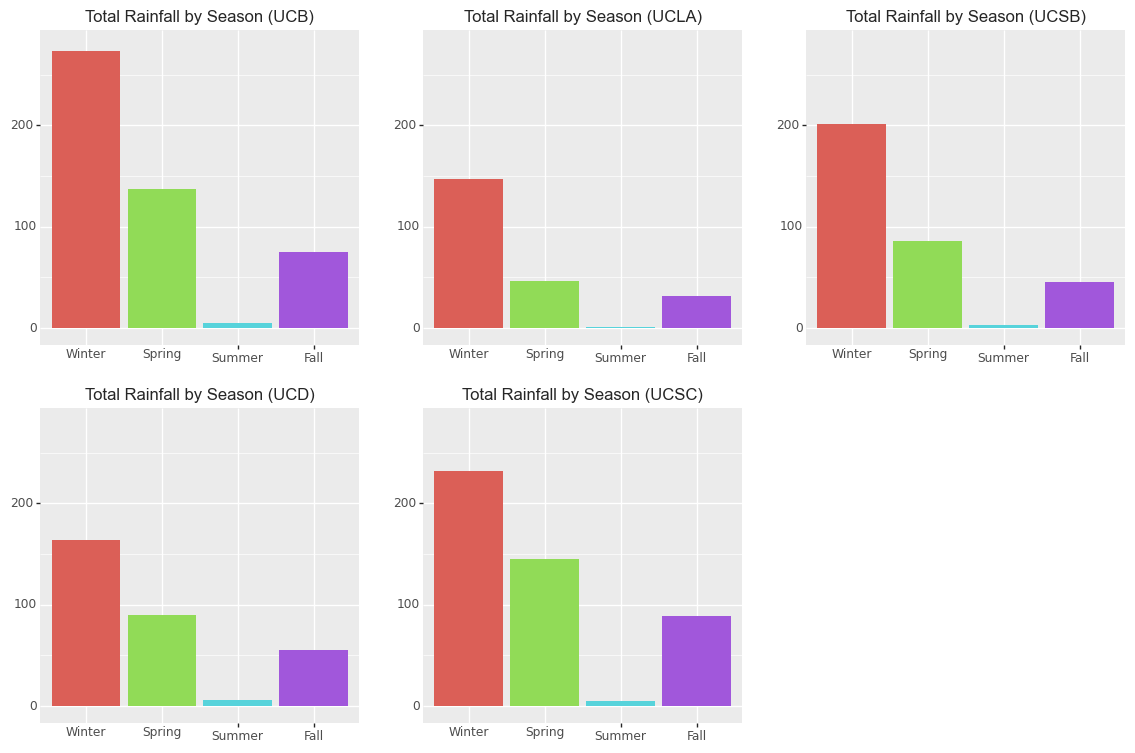

In [226]:
#combine all plots:
fig = (p9.ggplot()+p9.geom_blank(data=data.diamonds)+p9.theme_void()).draw()

# Create gridspec for adding subpanels to the blank figure
gs = gridspec.GridSpec(2,3)
ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[0,2])
ax4 = fig.add_subplot(gs[1,0])
ax5 = fig.add_subplot(gs[1,1])

#Add subplot titles:
ax1.set_title("Total Rainfall by Season (UCB)")
ax2.set_title("Total Rainfall by Season (UCLA)")
ax3.set_title("Total Rainfall by Season (UCSB)")
ax4.set_title("Total Rainfall by Season (UCD)")
ax5.set_title("Total Rainfall by Season (UCSC)")

# Add subplots to the figure
_ = p1._draw_using_figure(fig, [ax1])
_ = p2._draw_using_figure(fig, [ax2])
_ = p3._draw_using_figure(fig, [ax3])
_ = p4._draw_using_figure(fig, [ax4])
_ = p5._draw_using_figure(fig, [ax5])

fig.set_size_inches(14,9)

### Findings:
Here the data for the total rainfall is presented by geom_col() since it assists to present the actual value of the data on the height of the bar. Each year was classified by the four seasons and stored in a new variable called 'season'. Each season is presented by a bar with a different color, and measured by (mm) unit on the y-axis.

From the plots, we observe UCB and UCSC have the most rainfall on the four seasons throughout the twenty years span, and compared to the other selected UC's. UCLA has the least rainfall throughout the seasons on the four seasons throughout the twenty years.

We can also conclude that, for all of the UC campuses, winter is the wettest month, and summer is the dryest month. Students who prefer dryer climates may wish to apply to UCLA, while those who prefer a wetter climate may prefer to apply to UC Berkeley or UC Santa Cruz.

## 3.5. Total Rainfall by UC:
The purpose of this plot is to visualize total rainfall by each UC campus. Compared to the previous plot in section 3.4, this plot will be easier to visualize total rainfall by UC campus.

In [228]:
#make dataframe for total rainfall of each UC:
tot_rain = pd.DataFrame({
    "UC_Campus":["UCB","UCLA","UCSB","UCD","UCSC"],
    "total_rain":[berk_dat["Precip"].sum(),
                ucla_dat["rain"].sum(),
                ucsb_dat["rain"].sum(),
                df_davis["PRCP"].sum(),
                ucsc_dat["PRCP"].sum()]
})

In [229]:
tot_rain.head()

,UC_Campus,total_rain
0,UCB,490.75
1,UCLA,225.10
2,UCSB,335.38
3,UCD,313.91
4,UCSC,471.35


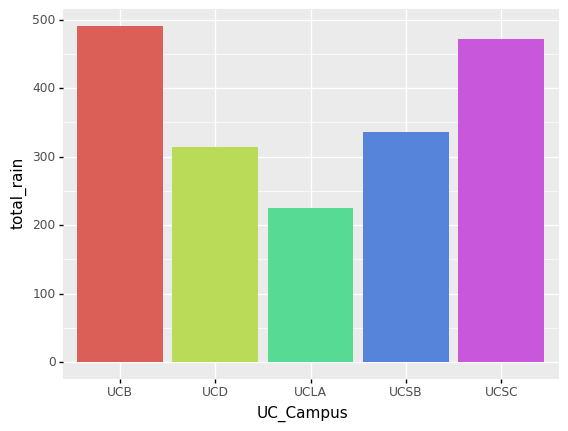

<ggplot: (185569007469)>

In [232]:
#plot of rain by UC:
pt = p9.ggplot(data= tot_rain)
pt += p9.aes(x = "UC_Campus", y = "total_rain", fill = "UC_Campus")
pt += p9.geom_col()
pt += p9.guides(fill = False)
pt

### Findings:
This plot illustrates the overall total rainfall trend throughout the twenty years for the selected 5 UC's. We observe UCB (University of California-Berkeley) and UCSC (University of California-Santa Cruz) have the most rainfall. UCLA (University of California-Los Angeles) has the least total rainfall throughout this 20 year time period.. 

# 4. Conclusions

Finally, we would like to wrap up our work and acknowledge our findings that climate change has indeed impacted the UC system. We performed the analysis by extracting useful data from the API of NOAA Climate Data Online (CDO). The extracted information was for the selected 5 UC’s: UC Berkeley, UC Davis, UC Los Angeles, UC Santa Barbara and UC Santa Cruz. We cleaned the data by modifying the dates to datetime objects, year, dropping missing values and creating a panda dataframe. This helped to plot visualizations with different geometries depending on the variable of interest. We have also presented the temperature over twenty years using geom_line() since it helps create a time series of change overtime. As well as geom_col() for some of the plots to present the actual values in the bins to see the value differences between the four seasons over the twenty year time span. Our work is organized in a jupyter notebook with docstrings classifying each section and making the code easier to understand, and interpretations for some of the plots where necessary. The codes have some comments to explain their purpose and also we ensured the visualizations have proper publication features.  

In addition to our findings, we have seen an increase on the maximum temperature in most of the UC’s and how most of them were having slight increases on the differences between maximum and minimum temperature per each year. This increase of warmer temperature is triggering constant heat waves, the expansion of wildfires, drought, less rain, health problems due to bad air quality and evacuating people from their homes. For example, at the University of California Santa Cruz, we observed how at the beginning of 2000 their warm weather was 65 degrees (F) and after 10 years until this date, their warm weather was above 70 degrees (F). Also, we can see that some places like University of California Los Angeles are having less rainfall while the warm weather is dramatically increasing over time.
	
For that reason, we would like to bring awareness and encourage UC students to work together towards preventing climate change. The more the climate change increases, the more the risks will grow and it will be hard to live in those UC’s. 

---